### 1. Importações

In [613]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [614]:
df_channels = pd.read_csv(r'C:\Users\Usuario\Documents\TREINAMENTO\PJ_treinamento3_24.0\Previsao-main\Previsao-main\channels.csv')
df_deliveries = pd.read_csv(r'C:\Users\Usuario\Documents\TREINAMENTO\PJ_treinamento3_24.0\Previsao-main\Previsao-main\deliveries.csv')
df_drivers = pd.read_csv(r'C:\Users\Usuario\Documents\TREINAMENTO\PJ_treinamento3_24.0\Previsao-main\Previsao-main\drivers.csv')
df_hubs = pd.read_csv(r'C:\Users\Usuario\Documents\TREINAMENTO\PJ_treinamento3_24.0\Previsao-main\Previsao-main\hubs.csv')
df_orders = pd.read_csv(r'C:\Users\Usuario\Documents\TREINAMENTO\PJ_treinamento3_24.0\Previsao-main\Previsao-main\orders.csv')
df_payments = pd.read_csv(r'C:\Users\Usuario\Documents\TREINAMENTO\PJ_treinamento3_24.0\Previsao-main\Previsao-main\payments.csv')
df_stores = pd.read_csv(r'C:\Users\Usuario\Documents\TREINAMENTO\PJ_treinamento3_24.0\Previsao-main\Previsao-main\stores.csv')

### 2. Unindo as bases

In [615]:
dfmerge1 = pd.merge(df_deliveries, df_drivers, on='driver_id')
dfmerge2 = pd.merge(df_stores, df_hubs, on='hub_id')
df = pd.merge(pd.merge(pd.merge(pd.merge(df_orders, df_channels, on='channel_id'), dfmerge1, on='delivery_order_id'), dfmerge2, on='store_id'), df_payments, on='payment_order_id')

### 3. Limpeza dos dados

#### 3.1. Dropando colunas que não influenciam na análise

In [616]:
df = df.drop(['store_id', 'channel_id', 'payment_order_id', 'delivery_order_id', 'delivery_id', 'driver_id','hub_id','payment_id'], axis=1)

df.columns

Index(['order_id', 'order_status', 'order_amount', 'order_delivery_fee',
       'order_delivery_cost', 'order_created_hour', 'order_created_minute',
       'order_created_day', 'order_created_month', 'order_moment_created',
       'order_moment_accepted', 'order_moment_ready', 'order_moment_collected',
       'order_moment_in_expedition', 'order_moment_delivering',
       'order_moment_delivered', 'order_moment_finished',
       'order_metric_collected_time', 'order_metric_paused_time',
       'order_metric_production_time', 'order_metric_walking_time',
       'order_metric_expediton_speed_time', 'order_metric_transit_time',
       'order_metric_cycle_time', 'channel_type', 'delivery_distance_meters',
       'delivery_status', 'driver_modal', 'driver_type', 'store_segment',
       'store_plan_price', 'store_latitude', 'store_longitude', 'hub_city',
       'hub_latitude', 'hub_longitude', 'payment_amount', 'payment_fee',
       'payment_method', 'payment_status'],
      dtype='object')

In [617]:
df.shape

(287459, 40)

In [618]:
df['payment_status'].value_counts()

payment_status
PAID          287111
CHARGEBACK       335
AWAITING          13
Name: count, dtype: int64

In [619]:
df['order_status'].value_counts()

order_status
FINISHED    287457
CANCELED         2
Name: count, dtype: int64

In [620]:
df['delivery_status'].value_counts()

delivery_status
DELIVERED     287343
DELIVERING       116
Name: count, dtype: int64

In [621]:
df = df[~df['payment_status'].isin(['CHARGEBACK', 'AWAITING'])]
df = df[~df['order_status'].isin(['CANCELED'])]
df = df[~df['delivery_status'].isin(['DELIVERING'])]

In [622]:
df = df.drop(['payment_status', 'order_status', 'delivery_status'], axis=1)

#### 3.2. Valores nulos

In [623]:
df.isnull().sum()

order_id                                  0
order_amount                              0
order_delivery_fee                        0
order_delivery_cost                    2636
order_created_hour                        0
order_created_minute                      0
order_created_day                         0
order_created_month                       0
order_moment_created                      0
order_moment_accepted                   510
order_moment_ready                     7956
order_moment_collected                17744
order_moment_in_expedition            37754
order_moment_delivering                2338
order_moment_delivered               271199
order_moment_finished                     2
order_metric_collected_time           24682
order_metric_paused_time              39187
order_metric_production_time           7958
order_metric_walking_time             43171
order_metric_expediton_speed_time     10032
order_metric_transit_time              2493
order_metric_cycle_time         

In [624]:
df['order_metric_paused_time'].fillna(0, inplace=True)
df['order_metric_collected_time'].fillna(0, inplace=True)
df['order_amount'].fillna(0, inplace=True)
df['payment_amount'].fillna(0, inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_23192\3005138569.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['order_metric_paused_time'].fillna(0, inplace=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_23192\3005138569.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

#### 3.3. Valores inconsistentes

In [625]:
df = df.drop_duplicates()
df = df.loc[df['order_metric_transit_time'] >= 0]
df = df.loc[df['order_metric_walking_time'] >= 0]
df = df.loc[df['order_metric_paused_time'] >= 0]
df = df.loc[df['order_metric_collected_time'] >= 0]
df = df.loc[df['order_metric_production_time'] >= 0]
df = df.loc[df['order_amount'] >= 0]
df = df.loc[df['payment_amount'] >= 0]

### 4. Análise do tempo de preparo

In [626]:
colunas_prep = ['order_metric_production_time', 'order_metric_paused_time', 'order_metric_collected_time', 'order_created_hour', 'order_created_minute', 'order_amount', 'payment_amount', 'channel_type']

In [627]:
df_preparo = df[colunas_prep]

In [628]:
df_preparo.columns

Index(['order_metric_production_time', 'order_metric_paused_time',
       'order_metric_collected_time', 'order_created_hour',
       'order_created_minute', 'order_amount', 'payment_amount',
       'channel_type'],
      dtype='object')

#### 4.1. Tempo circular

In [629]:
# Calculando a representação circular para as horas
df_preparo['hour_angle'] = (df_preparo['order_created_hour'] % 12) * 30 + (df_preparo['order_created_minute'] / 60) * 30
# Normalizando os ângulos para o intervalo [0, 360)
df_preparo['hour_angle'] = df_preparo['hour_angle'] % 360
df_preparo['radians'] = np.radians(df_preparo['hour_angle'])

# Visualizando o resultado
print(df_preparo[['order_created_hour', 'order_created_minute', 'hour_angle','radians']])

        order_created_hour  order_created_minute  hour_angle   radians
0                       15                    49       114.5  1.998402
1                       21                    19       279.5  4.878195
2                       20                    49       264.5  4.616396
3                       22                    35       317.5  5.541420
4                       16                    22       131.0  2.286381
...                    ...                   ...         ...       ...
287453                  18                    29       194.5  3.394665
287454                  22                    38       319.0  5.567600
287456                  16                    46       143.0  2.495821
287457                  16                    35       137.5  2.399828
287458                   0                     5         2.5  0.043633

[232142 rows x 4 columns]


C:\Users\Usuario\AppData\Local\Temp\ipykernel_23192\4063297737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preparo['hour_angle'] = (df_preparo['order_created_hour'] % 12) * 30 + (df_preparo['order_created_minute'] / 60) * 30
C:\Users\Usuario\AppData\Local\Temp\ipykernel_23192\4063297737.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preparo['hour_angle'] = df_preparo['hour_angle'] % 360
C:\Users\Usuario\AppData\Local\Temp\ipykernel_23192\4063297737.py:5: SettingWithCopyWarning: 
A value i

##### 4.2. TARGET

In [630]:
df_preparo = df_preparo.dropna(subset=['order_metric_production_time'])

#### 4.3. Outliers

In [631]:
def calcula_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    diff = q3 - q1
    lim_inf = q1 - 1.5 * diff
    lim_sup = q3 + 1.5 * diff
    outliers = column[(column < lim_inf) | (column > lim_sup)] # Definição de outliers pelos percentis e limites
    return outliers, lim_inf, lim_sup

# Função para contar outliers e calcular a porcentagem
def conta_outliers(df):
    outlier_info = pd.DataFrame(columns=['Coluna', 'Outliers', 'Porcentagem', 'lim_inf', 'lim_sup']) # Criando um novo DataFrame
    for col in df.select_dtypes(include=['int', 'float']): # Loop para verificar cada coluna numérica
        outliers, lim_inf, lim_sup = calcula_outliers(df[col]) # Chamando a função para calcular outliers
        outlier_count = len(outliers) # Verificando o tamanho da lista
        percentage = (outlier_count / len(df)) * 100 # Porcentagem de outliers
        outlier_info.loc[len(outlier_info)] = [col, outlier_count, percentage, lim_inf, lim_sup] # Atribuindo valores usando .loc[]
    return outlier_info # Retornando DataFrame

outlier_df = conta_outliers(df_preparo)
print(outlier_df)

                         Coluna  Outliers  Porcentagem     lim_inf     lim_sup
0  order_metric_production_time      9115     3.926476   -9.000000   39.000000
1      order_metric_paused_time     20244     8.720525   -5.000000   11.000000
2   order_metric_collected_time     14651     6.311223   -3.000000    5.000000
3            order_created_hour     20272     8.732586    4.500000   32.500000
4          order_created_minute         0     0.000000  -31.000000   89.000000
5                  order_amount     11688     5.034849  -74.500000  225.500000
6                payment_amount      9477     4.082415  -98.100000  249.900000
7                    hour_angle         0     0.000000 -203.000000  609.000000
8                       radians         0     0.000000   -3.543018   10.629055


In [632]:
df_preparo = df_preparo.drop(outlier_df[outlier_df['Coluna'] == 'order_metric_production_time'].index)
df_preparo = df_preparo.drop(outlier_df[outlier_df['Coluna'] == 'order_metric_paused_time'].index)
df_preparo = df_preparo.drop(outlier_df[outlier_df['Coluna'] == 'order_metric_collected_time'].index)
df_preparo = df_preparo.drop(outlier_df[outlier_df['Coluna'] == 'order_created_hour'].index)
df_preparo = df_preparo.drop(outlier_df[outlier_df['Coluna'] == 'order_amount'].index)
df_preparo = df_preparo.drop(outlier_df[outlier_df['Coluna'] == 'payment_amount'].index)

In [633]:
outlier_df = conta_outliers(df_preparo)

#### 4.4. Numéricas - Matriz de Correlação

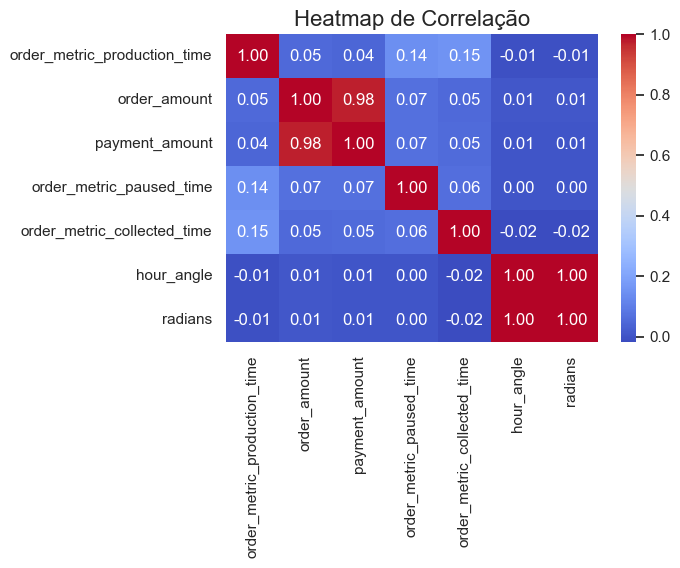

In [634]:
sns.set(style="white")
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(df_preparo[['order_metric_production_time', 'order_amount', 'payment_amount', 'order_metric_paused_time', 'order_metric_collected_time', 'hour_angle', 'radians']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
heatmap.set_title('Heatmap de Correlação', fontsize=16)
plt.show()

In [635]:
numericas = df_preparo.select_dtypes(exclude=['object','datetime']).columns

for coluna in numericas:
    data1 = df_preparo[coluna]
    data2 = df_preparo['order_metric_production_time']

    t_statistic, p_value = ttest_ind(data1, data2)

    print("\n")
    print(coluna)
    print("Estatística t:", t_statistic)
    print("Valor p:", p_value)



order_metric_production_time
Estatística t: 0.0
Valor p: 1.0


order_metric_paused_time
Estatística t: -52.25875671000521
Valor p: 0.0


order_metric_collected_time
Estatística t: -78.34933747935753
Valor p: 0.0


order_created_hour
Estatística t: -26.914380407925105
Valor p: 1.9784398225194768e-159


order_created_minute
Estatística t: 16.120391991075998
Valor p: 1.902859854782374e-58


order_amount
Estatística t: 167.05591486939755
Valor p: 0.0


payment_amount
Estatística t: 161.7977558363076
Valor p: 0.0


hour_angle
Estatística t: 462.1905111848078
Valor p: 0.0


radians
Estatística t: -73.80712546590681
Valor p: 0.0


#### 4.5. Categórica - ANOVA

In [636]:
df_preparo['channel_type'].value_counts()

channel_type
MARKETPLACE    214218
OWN CHANNEL     17918
Name: count, dtype: int64

In [637]:
# Suponha que 'categoria' é a coluna categórica e 'numerico' é a coluna numérica
MARKETPLACE = df_preparo[df_preparo['channel_type'] == 'MARKETPLACE']['order_metric_production_time']
OWNCHANNEL = df_preparo[df_preparo['channel_type'] == 'OWN CHANNEL']['order_metric_production_time']

# Executar ANOVA
stat, p_valor = f_oneway(MARKETPLACE, OWNCHANNEL)

# Interpretar o resultado
if p_valor < 0.05:
    print("Há evidências suficientes para rejeitar a hipótese nula. A coluna categórica influencia a coluna numérica.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula. A coluna categórica não influencia a coluna numérica.")

Há evidências suficientes para rejeitar a hipótese nula. A coluna categórica influencia a coluna numérica.


#### 4.6. Modelo

In [638]:
troca_channel = {'MARKETPLACE': 1, 'OWN CHANNEL': 0}
df_preparo['channel_type'] = df_preparo['channel_type'].map(troca_channel)

In [640]:
def preparacao(tab):
    dados = tab.copy()
    order_metric_production_time = dados.pop("order_metric_production_time")
    return dados, order_metric_production_time

tam_div = round(0.8 * len(df_preparo)) # Tamanho da separação
tab_treino = df_preparo.iloc[:tam_div] # Definindo parte a ser utilizada para treino
tab_valid = df_preparo.iloc[tam_div:] # Definindo parte a ser utilizada para verificação

# Dados
X_treino = preparacao(tab_treino)[0]
X_valid = preparacao(tab_valid)[0]

Y_treino = preparacao(tab_treino)[1]
Y_valid = preparacao(tab_valid)[1]

#LinearRegression
modelo_preparo = LinearRegression()

modelo_preparo.fit(X_treino, Y_treino) # Treinando o regressor
Y_prev_valid = modelo_preparo.predict(X_valid) # Prevendo os valores

# Calcular o MSE
mse = mean_squared_error(Y_valid, Y_prev_valid)
print('MSE:', mse) # Exibindo o MSE

r2 = r2_score(Y_valid, Y_prev_valid)
print('R²:', r2) # Exibindo o R²

MSE: 16967.866220590215
R²: 0.03401007535424394
